# LSTM 4
### * lag, ma, 변동률(pct) 중심 시계열 특화 피처만
### * Bidirectional LSTM


In [ ]:
!pip install tensorflow scikit-learn pandas numpy matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/all_features.csv', index_col=0, parse_dates=True)

In [ ]:
# 쉼표 제거 및 숫자형 변환
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 결측치 제거
df = df.dropna()

In [ ]:
target_col = '원/미국달러(매매기준율)'

# 타깃 기준 파생
df['환율_lag1'] = df[target_col].shift(1)
df['환율_ma3'] = df[target_col].rolling(3).mean()
df['환율_pct'] = df[target_col].pct_change()
df['환율_diff'] = df[target_col].diff()

# 자산 가격 관련
for col in ['금', '은', '원유', 'KOSPI', 'NASDAQ']:
    df[f'{col}_pct'] = df[col].pct_change()
    df[f'{col}_diff'] = df[col].diff()

# 금리 관련
for col in ['국고채(3년)(%)', '국고채(10년)(%)', '기준금리', 'CD(91일)', '무담보콜금리(1일, 전체거래)']:
    df[f'{col}_diff'] = df[col].diff()

# 무역 지표
for col in ['수출물가지수(달러기준)', '수입물가지수(달러기준)']:
    df[f'{col}_pct'] = df[col].pct_change()

# 심리지표
for col in ['뉴스심리지수', '경제심리지수', '미국 소비자심리지수']:
    df[f'{col}_diff'] = df[col].diff()

df = df.dropna()

In [ ]:
# 'lag', 'ma', 'pct', 'diff' 포함된 컬럼만 선택
selected_cols = [col for col in df.columns if any(kw in col.lower() for kw in ['lag', 'ma', 'pct', 'diff'])]
X = df[selected_cols]
y = df[target_col]

In [ ]:
# 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# 시퀀스 (30일 → 60일)
def create_sequences(X, y, seq_len=60):
    Xs, ys = [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=60)

In [ ]:
# train/test
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [ ]:
# Bidirectional LSTM 모델
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    callbacks=[es]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - loss: 0.1983 - val_loss: 0.0135
Epoch 2/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - loss: 0.0334 - val_loss: 0.0120
Epoch 3/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0192 - val_loss: 0.0113
Epoch 4/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - loss: 0.0167 - val_loss: 0.0117
Epoch 5/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - loss: 0.0238 - val_loss: 0.0164
Epoch 6/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - loss: 0.0382 - val_loss: 0.0089
Epoch 7/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 0.0173 - val_loss: 0.0116
Epoch 8/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 0.0213 - val_loss: 0.0092
Epoch 9/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0247 - val_loss: 0.0099
Epoch 10/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 22s 125ms/step - loss: 0.0161 - val_loss: 0.0102
Epoch 11/100
165/165 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - loss: 0.0191 - val_loss: 0.0068
Epoch 12

In [ ]:
# 정규화 복원 (역변환)
y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step


In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("LSTM 4 예측 성능")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

LSTM 4 예측 성능
MSE: 220.12
MAE: 10.83
RMSE: 14.84
R²: 0.9740


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# 1. 모델 빌드 함수 정의
def build_lstm_model(seq_len, n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(seq_len, n_features)))
    model.add(Dropout(0.2))  # 너가 튜닝한 Dropout 반영
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 2. 교차검증 파라미터 세팅
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X_seq) * 0.6)  # 초기 학습 데이터 크기 (60%)
step_size = int(len(X_seq) * 0.1)        # 검증 데이터 크기 (10%)

# 3. Time Series 교차검증 루프
for i, start in enumerate(range(initial_window, len(X_seq) - step_size, step_size)):
    print(f"\n📦 Fold {i+1}")

    # 학습/검증 데이터 분리
    X_train_cv, y_train_cv = X_seq[:start], y_seq[:start]
    X_val_cv, y_val_cv = X_seq[start:start + step_size], y_seq[start:start + step_size]

    # 모델 생성
    model = build_lstm_model(seq_len=X_train_cv.shape[1], n_features=X_train_cv.shape[2])

    # EarlyStopping 설정
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 학습
    model.fit(
        X_train_cv, y_train_cv,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,
        callbacks=[es],
        verbose=0
    )

    # 검증 데이터 예측
    y_pred_cv = model.predict(X_val_cv, verbose=0)

    # 성능 측정
    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# 4. 전체 평균 결과 출력
print("\n📊 전체 평균 성능")
print(f"▶ 평균 MSE : {np.mean(mse_scores):.4f}")
print(f"▶ 평균 MAE : {np.mean(mae_scores):.4f}")
print(f"▶ 평균 R²  : {np.mean(r2_scores):.4f}")


📦 Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  ✅ MSE: 0.0039, MAE: 0.0501, R²: 0.9098

📦 Fold 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  ✅ MSE: 0.0064, MAE: 0.0607, R²: 0.9390

📦 Fold 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  ✅ MSE: 0.0179, MAE: 0.0848, R²: 0.9646

📦 Fold 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  ✅ MSE: 0.0142, MAE: 0.0956, R²: 0.9017

📊 전체 평균 성능
▶ 평균 MSE : 0.0106
▶ 평균 MAE : 0.0728
▶ 평균 R²  : 0.9288


### 실제 예측률

In [ ]:
# ✅ 마지막 60일 기준으로 3월 예측 시작 (LSTM 출력 = 환율 그 자체)
last_60_X = X_scaled[-60:].copy()  # (60, 변수 수)
predicted_rates = []

for _ in range(31):  # 3월 예측: 31일
    # 입력은 항상 최신 60일
    pred = model.predict(last_60_X.reshape(1, 60, -1), verbose=0)

    # 스케일 복원 (환율 자체 예측)
    pred_rate = scaler_y.inverse_transform(pred)[0][0]
    predicted_rates.append(pred_rate)

    # 다음 입력 구성: 마지막 행 복사해서 사용 (예측값으로는 X 못 업데이트하므로 관측된 최신 피처 그대로 유지)
    next_input = last_60_X[-1].copy()  # 구조 유지용
    last_60_X = np.vstack([last_60_X[1:], next_input])  # 단순한 sliding window

# ✅ 변화율 계산 (전일 대비 비율 변화 %)
predicted_returns = [0]  # 첫 날은 변화율 없음
for i in range(1, len(predicted_rates)):
    change = (predicted_rates[i] - predicted_rates[i-1]) / predicted_rates[i-1] * 100
    predicted_returns.append(change)

# ✅ 결과 출력
future_dates = pd.date_range(start="2025-03-01", periods=31)
pred_df = pd.DataFrame({
    "DATE": future_dates,
    "예측_환율": predicted_rates,
    "예측_변화율(%)": predicted_returns
})

print("📊 LSTM 기반 3월 환율 예측 결과 (환율 자체 예측 기준):")
print(pred_df.to_string(index=False))

📊 LSTM 기반 3월 환율 예측 결과 (환율 자체 예측 기준):
      DATE       예측_환율  예측_변화율(%)
2025-03-01 1446.531128   0.000000
2025-03-02 1458.214600   0.807689
2025-03-03 1456.662354  -0.106448
2025-03-04 1451.735474  -0.338231
2025-03-05 1443.083862  -0.595950
2025-03-06 1439.642090  -0.238501
2025-03-07 1434.597046  -0.350437
2025-03-08 1428.888306  -0.397933
2025-03-09 1423.410278  -0.383377
2025-03-10 1421.572876  -0.129085
2025-03-11 1417.955811  -0.254441
2025-03-12 1415.287720  -0.188165
2025-03-13 1413.451904  -0.129713
2025-03-14 1411.265747  -0.154668
2025-03-15 1411.177246  -0.006271
2025-03-16 1407.140015  -0.286090
2025-03-17 1403.690552  -0.245140
2025-03-18 1404.784058   0.077902
2025-03-19 1403.692017  -0.077737
2025-03-20 1403.024902  -0.047526
2025-03-21 1402.040894  -0.070135
2025-03-22 1400.878052  -0.082939
2025-03-23 1399.081787  -0.128224
2025-03-24 1400.929077   0.132036
2025-03-25 1400.497681  -0.030794
2025-03-26 1400.417725  -0.005709
2025-03-27 1400.813354   0.028251
2025-03-28 

<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 45804 (\N{HANGUL SYLLABLE DAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-7bacf1c155a6>:11: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipy

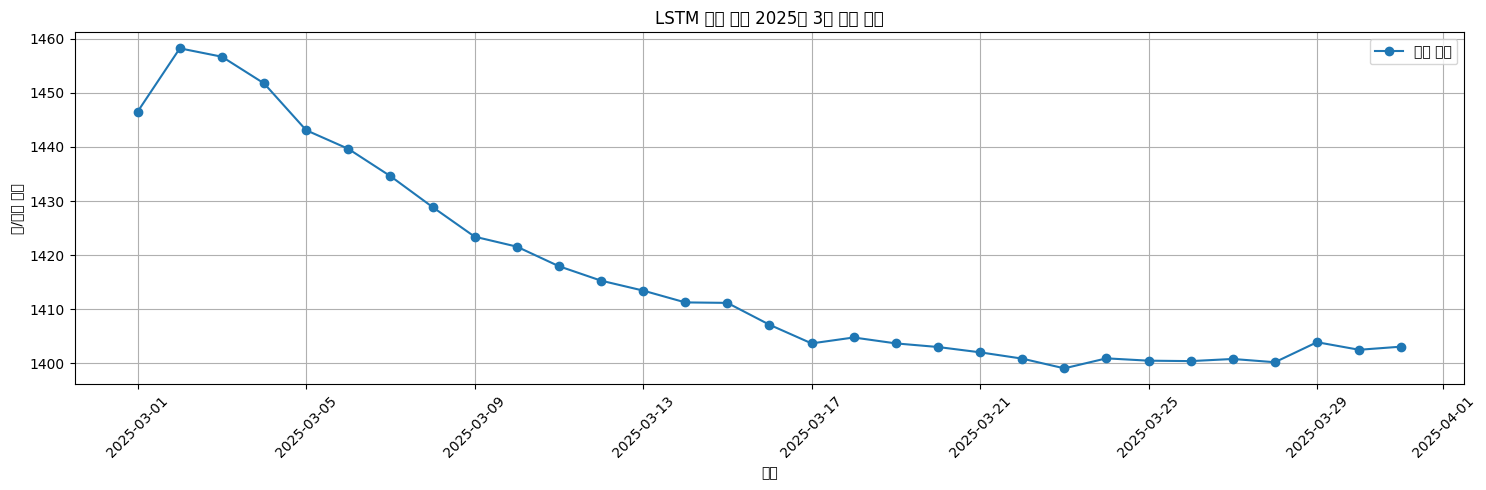

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(pred_df["DATE"], pred_df["예측_환율"], label='예측 환율', marker='o')
plt.title("LSTM 예측 기반 2025년 3월 환율 전망")
plt.xlabel("날짜")
plt.ylabel("원/달러 환율")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# 3월 1일부터 3월 31일까지의 환율 데이터 다운로드
df_real = yf.download('USDKRW=X', start='2025-03-01', end='2025-04-01')

# 'Close' 열을 '실제 환율'로 이름 변경
df_real = df_real[['Close']].rename(columns={'Close': '실제 환율'})

# 인덱스를 'DATE' 열로 변환
df_real.reset_index(inplace=True)
df_real['DATE'] = df_real['Date'].dt.date
df_real.drop(columns=['Date'], inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
<ipython-input-18-19db9b7537c4>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_real.drop(columns=['Date'], inplace=True)


In [ ]:
print(df_real.head())

Price         실제 환율        DATE
Ticker     USDKRW=X            
0       1459.800049  2025-03-03
1       1457.930054  2025-03-04
2       1452.849976  2025-03-05
3       1443.030029  2025-03-06
4       1446.500000  2025-03-07


In [ ]:
pred_df = pred_df.sort_values(by='DATE').reset_index(drop=True)
df_real = df_real.sort_values(by='DATE').reset_index(drop=True)

In [ ]:
# 예측 데이터프레임에 실제 환율 열 붙이기 (순서 기준)
pred_df['실제 환율'] = df_real['실제 환율']

# 오차 계산
pred_df['예측 오차(원)'] = pred_df['예측_환율'] - pred_df['실제 환율']
pred_df['예측 오차율(%)'] = pred_df['예측 오차(원)'] / pred_df['실제 환율'] * 100

In [ ]:
print("📊 예측 vs 실제 비교 결과 (병합 없이 정렬 기반):")
print(pred_df[['DATE', '예측_환율', '실제 환율', '예측 오차(원)', '예측 오차율(%)']].to_string(index=False))

📊 예측 vs 실제 비교 결과 (병합 없이 정렬 기반):
      DATE       예측_환율       실제 환율   예측 오차(원)  예측 오차율(%)
2025-03-01 1446.531128 1459.800049 -13.268921  -0.908955
2025-03-02 1458.214600 1457.930054   0.284546   0.019517
2025-03-03 1456.662354 1452.849976   3.812378   0.262407
2025-03-04 1451.735474 1443.030029   8.705444   0.603275
2025-03-05 1443.083862 1446.500000  -3.416138  -0.236166
2025-03-06 1439.642090 1446.260010  -6.617920  -0.457589
2025-03-07 1434.597046 1457.030029 -22.432983  -1.539638
2025-03-08 1428.888306 1451.020020 -22.131714  -1.525252
2025-03-09 1423.410278 1448.750000 -25.339722  -1.749075
2025-03-10 1421.572876 1453.229980 -31.657104  -2.178396
2025-03-11 1417.955811 1449.050049 -31.094238  -2.145836
2025-03-12 1415.287720 1442.489990 -27.202271  -1.885786
2025-03-13 1413.451904 1448.939941 -35.488037  -2.449241
2025-03-14 1411.265747 1443.390015 -32.124268  -2.225612
2025-03-15 1411.177246 1465.819946 -54.642700  -3.727791
2025-03-16 1407.140015 1464.780029 -57.640015  -3.935063

<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-23-74bae80f24ea>:11: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<

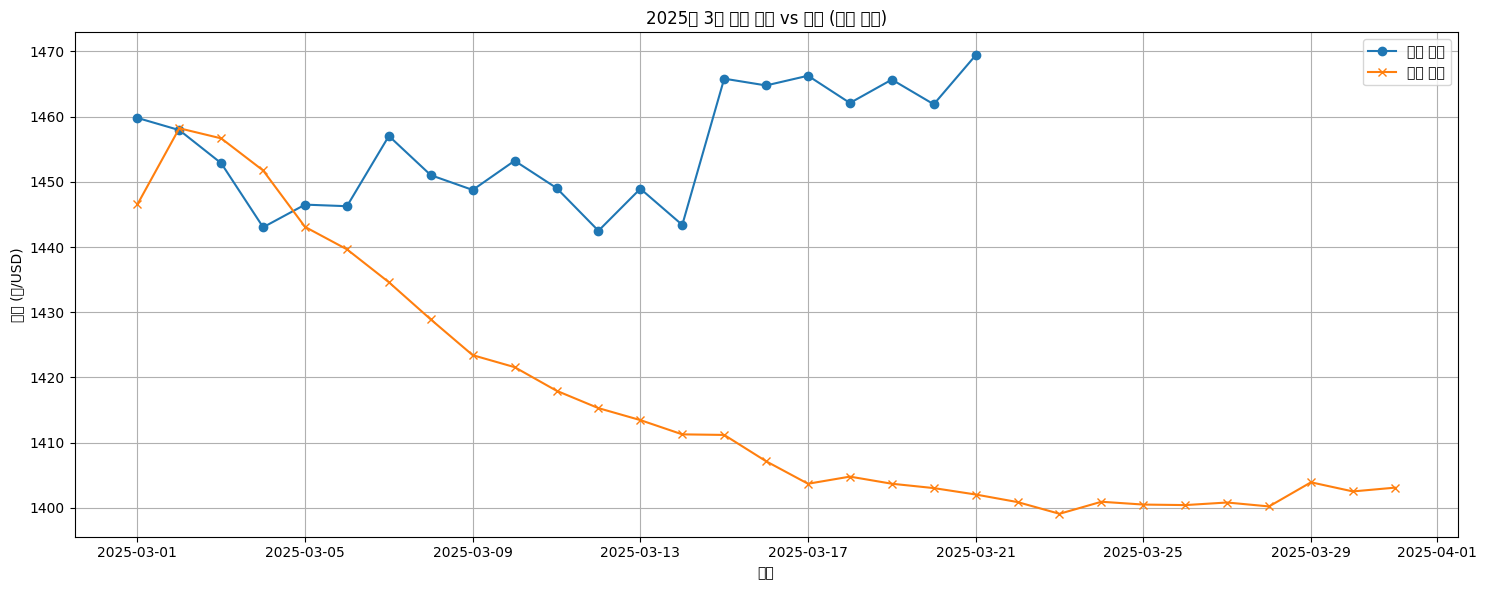

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(pred_df['DATE'], pred_df['실제 환율'], label='실제 환율', marker='o')
plt.plot(pred_df['DATE'], pred_df['예측_환율'], label='예측 환율', marker='x')
plt.title("2025년 3월 환율 예측 vs 실제 (정렬 기반)")
plt.xlabel("날짜")
plt.ylabel("환율 (원/USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### train/test loss

In [ ]:
import matplotlib.pyplot as plt

# 학습 기록 시각화
def plot_training_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.title('train/test loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

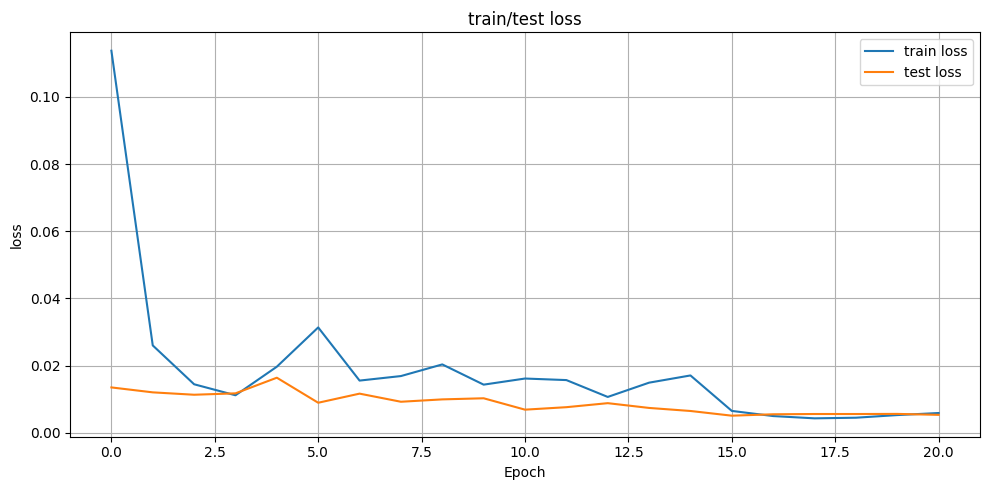

In [ ]:
plot_training_history(history)

In [ ]:
def evaluate_history(history):
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']

    result = {
        '최종 훈련 손실': train_losses[-1],
        '최종 검증 손실': val_losses[-1],
        '최소 훈련 손실': min(train_losses),
        '최소 검증 손실': min(val_losses),
        '최소 손실 차이': abs(min(train_losses) - min(val_losses)),
        '최소 검증 손실 발생 에포크': val_losses.index(min(val_losses)) + 1
    }

    return pd.DataFrame(result, index=['값'])

In [ ]:
evaluate_history(history)

,최종 훈련 손실,최종 검증 손실,최소 훈련 손실,최소 검증 손실,최소 손실 차이,최소 검증 손실 발생 에포크
값,0.005846,0.005298,0.00426,0.005052,0.000792,16


In [ ]:
import pandas as pd
import numpy as np

# 마지막 60일 데이터 (seq_len=60)
last_60_X = X_scaled[-60:].copy()

# 마지막 실제 환율
last_rate = df[target_col].iloc[-1]

# 예측일 계산
start_date = pd.to_datetime(df.index[-1]) + pd.Timedelta(days=1)
target_date = pd.to_datetime("2025-05-13")
days_to_predict = (target_date - start_date).days + 1  # 오늘 다음날부터 5/13일까지 예측해야 하는 일수

predicted_returns = []  # 변화율 저장
predicted_rates = [last_rate]  # 실제 환율 저장 (초기값은 마지막 실제 환율)

# 예측 루프
for _ in range(days_to_predict):
    # 마지막 60일 데이터 기준 예측
    pred = model.predict(last_60_X.reshape(1, 60, -1), verbose=0)
    pred_return = scaler_y.inverse_transform(pred)[0][0] / 100  # 변화율 복원
    predicted_returns.append(pred_return * 100)  # %로 저장
    next_rate = predicted_rates[-1] * (1 + pred_return)
    predicted_rates.append(next_rate)

    # 마지막 60일 시퀀스 업데이트 (새 예측을 추가)
    last_60_X = np.vstack([last_60_X[1:], last_60_X[-1]])

# 최종 결과
predicted_rates = predicted_rates[1:]  # 초기값 제외

# 날짜 생성
future_dates = pd.date_range(start=start_date, periods=days_to_predict)

# 결과 데이터프레임
pred_df = pd.DataFrame({
    "DATE": future_dates,
    "예측_환율": predicted_rates,
    "예측_변화율(%)": predicted_returns
})

# 5월 13일 결과 출력
result_513 = pred_df[pred_df['DATE'] == target_date]
print("📈 2025년 5월 13일 환율 예측 결과:")
print(result_513)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


ValueError: Found array with dim 3. None expected <= 2.